# Question 1

In this question we will:

- Implement a segmentation algorithm that uses random walker as the primary means to segment a noisy version of the leaf dataset from the previous assignment.
- Evaluate the performance of our algorithm in terms of mean Dice coefficient.
- Examine the best and worst results that we get from the dataset.
- Reason on why the algorithm works well on the 'best' cases and what causes it to fail on the 'worst' cases.



# Step 1: Write your Segmentation Algorithm

Write a function that segments a leaf image, and returns a binary (`dtype='bool'`) image representing the segmentation.  You may add additional parameters besides the image to be segmented if you wish.  Your algorithm must use the random-walker segmentation (``skimage.segmentation.random_walker()``) and you should consider doing some region processing after segmentation to improve the result.

Let's assume that, for the purposes of this, that de-noising the images would be too expensive because
our application has to run on a mobile device.   Thus, you are not allowed to denoise the images before applying the
random walker algorithm.

_Hint: The challenge here is to automatically find suitable foreground and background markers for the random walker algorithm.  The noisy images make for an additional challenge, but that's why we're using random walker; becuase of its robustness to noise._

_Hint: When you use `random_walker()` on a color image, make sure to set `channel_axis=2`._

_Hint: you may need to adjust the `beta` and `tol` arguments to the `ramdom_walker()` function to get excellent results._

_Hint: Output of the `random_walker()` function may be further post-processed using region processing methods._

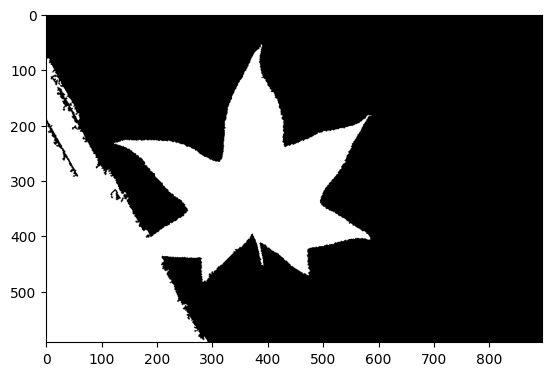

In [359]:
import skimage.util as util
import skimage.io as io
import numpy as np
import os as os
import matplotlib.pyplot as plt
import skimage.filters as filt
import skimage.color as skcolor
import skimage.morphology as morph
import skimage.segmentation as seg
import skimage.color as color
import skimage.measure as meas
import skimage.exposure as exposure

def segleaf(I):
    '''
    Segment a leaf image.
    :param I: Color leaf image to segment.
    :return: Logical image where True pixels represent foreground (i.e. leaf pixels).
    '''
    I = util.img_as_float(I)
    I_R, I_G, I_B = I[:, :, 0], I[:, :, 1], I[:, :, 2]
    
    greenness = I_G - I_R - I_B
    # greenness = I[:,:,1] / (np.sum(I, axis=2) + .0000001)
    greenness = exposure.rescale_intensity(greenness)
    seeds = np.zeros_like(greenness, dtype=np.float32)
    
    # seeds[greenness < 0.1] = 1  # bg label
    # seeds[greenness >= 0.2] = 2 # fg label
    
    seeds[greenness < 0.1] = 1  # bg label
    seeds[greenness >= 0.2] = 2 # fg label
    
    labels = seg.random_walker(greenness, seeds, prob_tol=1)
    
    binary = labels == 2
    
    binary = morph.binary_closing(binary, footprint= morph.disk(1))
    
    binary = morph.remove_small_objects(binary, min_size= 1024)
    binary = morph.remove_small_holes(binary, area_threshold=128) 
    
    
    labeled_mask = morph.label(binary,connectivity=1)
    leaf_only_mask = np.zeros(binary.shape, dtype=bool)
    

    for region in meas.regionprops(labeled_mask):
        
        aspect_ratio = region.major_axis_length / region.minor_axis_length if region.minor_axis_length > 0 else 0
        
        if (51000< region.area < 550000 and 
            region.eccentricity < 0.88 and 
            region.extent < 0.9 and
            1 < aspect_ratio < 4.0):
        
            leaf_only_mask[labeled_mask == region.label] = True
        # print(region.area, region.eccentricity, region.extent, aspect_ratio) 
            
    return leaf_only_mask

plt.figure()
plt.imshow(segleaf(io.imread("/u1/cmpt487-819/data/asn4/noisyimages/image_0018.png")),cmap= 'gray')




# Step 2: Write a Validation driver program.

Write code that segments each image, and computes the DSC for each segmentation.  Print the DSC of each segmentation as you perform it.  At the end, print the average of the DSC over all of the images. 

The general approach should be similar to Assignment 3.  For each input image (in the `noisyimages` directory):

* load the noisy image and it's ground truth
* segment the input image using the function you wrote in Step 1.
* Compute the DSC from the segmented image and the ground truth image (this function is given below).
* Print the DSC to the console.

When finished, print the average DSC for all images.  If you're getting a mean DSC of greater than 0.85, you're doing pretty good.

_Feel free to define additional helper functions for your program if you think it will help._

In [355]:
def dice_coefficient(bwA, bwG):
    '''
    Dice coefficient between two binary images
    :param bwA: a binary (dtype='bool') image
    :param bwG: a binary (dtype='bool') image
    :return: the Dice coefficient between them
    '''
    intersection = np.logical_and(bwA, bwG)

    return 2.0*np.sum(intersection) / (np.sum(bwA) + np.sum(bwG))

# Write your validation driver here.  It should be structured similarly to the driver in Assignment 3.  Again the image.csv file is provided with the names
# of all files to be processed.
import os
import pandas as pd

images_path = '/u1/cmpt487-819/data/asn4/noisyimages/'
gt_path = '/u1/cmpt487-819/data/asn4/groundtruth/'

files = pd.read_csv("/u1/cmpt487-819/data/asn4/images.csv", header=None)
file_list = files[0].tolist()


dsc_list = []
recognized_count = 0
total_images = 0


for filename in file_list:

    image_path = os.path.join(images_path, filename)
    gt_image_path = os.path.join(gt_path, filename)
    
    image = io.imread(image_path)
    ground_truth = io.imread(gt_image_path)
    
    segmented_image = segleaf(image)
    
    dsc = dice_coefficient(segmented_image, ground_truth > 0)
    
    print(f"DSC for {filename}: {dsc}")
    print("-" * 50)
    
    dsc_list.append(dsc)

    if dsc > 0.6:
        recognized_count += 1
    total_images += 1

mean_dsc = np.mean(dsc_list)
std_dsc = np.std(dsc_list)
recognition_percentage = (recognized_count / total_images) * 100

print("----------------------------------------------------")
print(f"The mean Dice coefficient was: {mean_dsc}")
print(f"The std. deviation of Dice coefficient was: {std_dsc}")
print("Minimum DSC is ",min(dsc_list))
print(f"{recognition_percentage}% of leaves were recognized.")
print("recognized_count is ", recognized_count)
print("total_images is ", total_images)

DSC for image_0001.png: 0.993106808261296
--------------------------------------------------
DSC for image_0002.png: 0.9886802521428809
--------------------------------------------------
DSC for image_0005.png: 0.9863601217803122
--------------------------------------------------
DSC for image_0007.png: 0.9919914949793508
--------------------------------------------------
DSC for image_0009.png: 0.7117299839016271
--------------------------------------------------
DSC for image_0010.png: 0.9937864717037507
--------------------------------------------------
DSC for image_0011.png: 0.9898236410052228
--------------------------------------------------
DSC for image_0015.png: 0.990354609929078
--------------------------------------------------
DSC for image_0018.png: 0.6838522847569137
--------------------------------------------------
DSC for image_0019.png: 0.9884681868769387
--------------------------------------------------
DSC for image_0078.png: 0.9886927602967511
-------------------

# Step 3:  Display Examples

Choose one input image where your algoirthm performed very well.  Choose another image where the algorithm did not perform well.  Display the two original images with the segmentation superimposed on top (just like Step 4 in of assignment 3).  Also display the same two image's ground truth with the segmentation superimposed on top.    Title the images to indicate which is the "good" example, and which is the "bad" example.


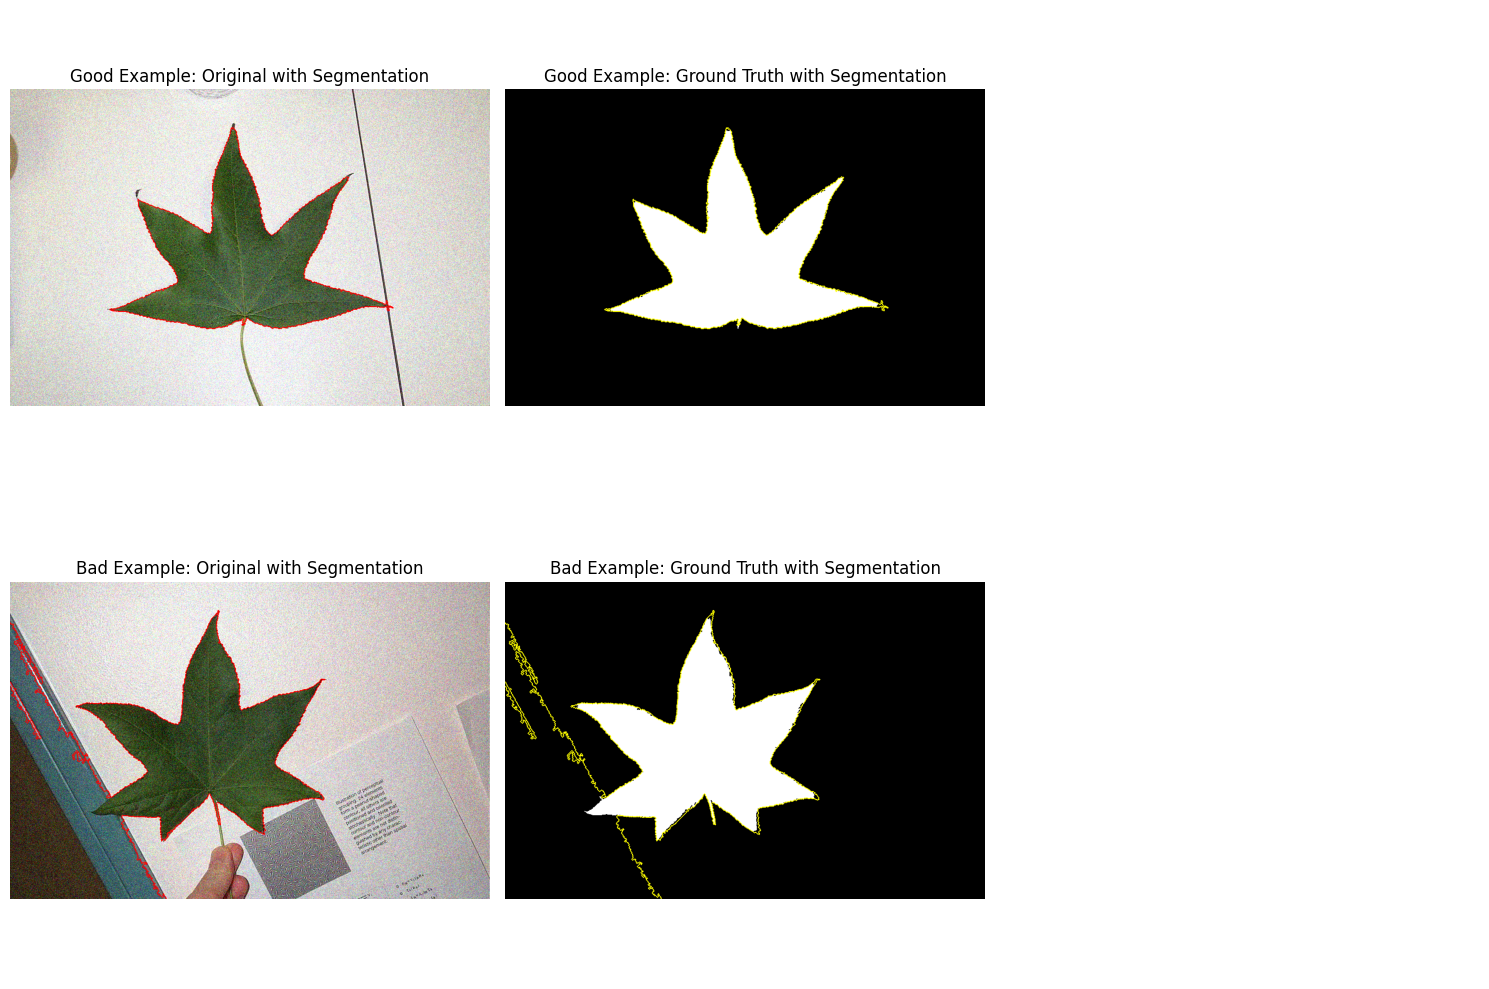

In [361]:
import matplotlib.pyplot as plt
good_example = 'image_0001.png'
bad_example = 'image_0018.png'

images_path = '/u1/cmpt487-819/data/asn4/noisyimages/'
gt_path = '/u1/cmpt487-819/data/asn4/groundtruth/'


def get_segmented_image_with_boundaries(image_file):

    image = io.imread(images_path + image_file)
    ground_truth = io.imread(gt_path + image_file)
    
    segmented_image = segleaf(image)
    
    labeled_segmentation = morph.label(segmented_image)
    image_with_boundaries = seg.mark_boundaries(image, labeled_segmentation, color=(1, 0, 0), mode = "thick")
    
    ground_truth_with_boundaries = seg.mark_boundaries(ground_truth, labeled_segmentation, color=(1, 1, 0),mode = "thick")
    
    return image_with_boundaries, ground_truth_with_boundaries

good_image_with_seg, good_gt_with_seg = get_segmented_image_with_boundaries(good_example)
bad_image_with_seg, bad_gt_with_seg = get_segmented_image_with_boundaries(bad_example)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(good_image_with_seg)
plt.title("Good Example: Original with Segmentation")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(good_gt_with_seg, cmap='gray')
plt.title("Good Example: Ground Truth with Segmentation")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(bad_image_with_seg)
plt.title("Bad Example: Original with Segmentation")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(bad_gt_with_seg, cmap='gray')
plt.title("Bad Example: Ground Truth with Segmentation")
plt.axis('off')

# Empty subplots (optional)
plt.subplot(2, 3, 3)
plt.axis('off')

plt.subplot(2, 3, 6)
plt.axis('off')

plt.tight_layout()
plt.show()

# Step 4: Reflection

### Answer the following questions right here in this block.

1. In a few sentences, briefly explain what your segmentation algorithm from Step 1 does and how it works.  

	_Your answer:_  The segmentation algorithm segleaf extracts a leaf from a color image by analyzing the “greenness” of pixels. It computes a “greenness” metric by subtracting the red and blue channels from the green channel, enhancing the contrast of green areas associated with leaves. Based on intensity values, it creates background and foreground seeds for the random_walker algorithm, which segments the image based on these seeds. Post-segmentation, the algorithm refines the result using morphological operations to close small gaps, remove small objects, and filter regions based on criteria like area, eccentricity, extent, and aspect ratio to isolate the leaf shape accurately.

2. Consider your good result.  What, if anything, about your algoirthm is preventing you from getting a better result with this image?  If you weren't able to get any results, leave this blank, or explain what was preventing you from getting a result.

	_Your answer:_  The algorithm performs fairly good on "good" example image as the dsc score suggests, the score varies probably because of deviation in some boundary points which could be fixed by making some parametric adjustments to get_boundaries function or even paying more attention to shape and boundary descriptors in segleaf funcion.

3. Consider your bad result.  What is it about your algoirthm caused the poor performance on this image?   If you weren't able to get any results, leave this blank.

	_Your answer:_ ("The images are noisy" is not an acceptable answer.  Be more specific -- if noise is the problem, explain why your algorithm can't overcome the noise; what is preventing it, or what does it need to do better to succeed?)
    The algorithm is not able to properly segment out other green areas like in image_0018.png , which is because the greenness extraction metric i used is not perfect enough in extracting just the green intensities of the leaves and is not able to filter out other green things that appear as connected component of green leaves.
